# Powerlifting Trend and Forecasting 

## Inspiration

The road to break the 4 minute mile was a very arduous road until Roger Bannister broke the barrier in 1954. Many people always thought it would be impossible, however he was able to prove them wrong. After it was broken, it seemed as though an increasing amount of people over the years were able to decrease this time. We hear it time and time again that our physical body is dictated by what our mind perceives.

An unyeilding belief is ones ability to break through barriers set by others create champions. While others see a new obstacle, others simply run through them. This could be generalized towards any sport, not just running.

This is where powerlifting becomes an interesting point of study. It is the measure of an individual's strength in three lifts: The Squat, Bench press, and Deadlift. It is always interesting to see outsiders of the sport stare in awe when they first see someone handle weights excess of 600lbs. Yet little do they know the top competitors of the sport are handling weights well over 900lbs in any of the three lifts. 

The 4 minute mile comparison to powerlifting is a 3000lb total, 1000lbs in each respective lift. However, what about those who are normal competitors, the "average" folks in the sport. We must not simply shrug them off since the amount of weight they are able to handle are still impressive. 

##### This begs to question, is there an increasing trend of these three lifts and the combined total over the years? Or are we stuck in an age of "no one will break the 4 minute mile"? 

To answer this question, Males and Females are separated first, we can not compare males and females in the same weight class since females numbers will inherently be lower than males. Next, the use of equipment will be removed. Equiped powerlifting is a small subset of the sport, and the use of equipment other than knee wraps, knee sleeves, etc etc will only inflate the numbers since they are very scarce. 

Next, we will categorize the age of each competitor, then weight classes will be segmented and the top 2-3 weightclasses with the most data points will be analyzed. For this analysis, we will focus on the 20-30 age bracket (they are the bulk of the competitors). 

##### Lastly, we want to find the total / Squat, Bench, Dead numbers will be forecasted to produce an interval of possible average weight lifted in the future, "when will the 4 minute equivalent be broken in powerlifting for each weight class?"

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
import itertools

In [2]:
op_df = pd.read_csv('openpowerlifting.csv')
op_df.tail()

,MeetID,Name,Sex,Equipment,Age,Division,BodyweightKg,WeightClassKg,Squat4Kg,BestSquatKg,Bench4Kg,BestBenchKg,Deadlift4Kg,BestDeadliftKg,TotalKg,Place,Wilks
386409,8481,William Barabas,M,Multi-ply,NaN,Elite,113.58,125,NaN,NaN,NaN,NaN,NaN,347.5,347.5,2,202.60
386410,8481,Justin Zottl,M,Multi-ply,NaN,Elite,119.02,125,NaN,NaN,NaN,NaN,NaN,322.5,322.5,3,185.77
386411,8481,Jake Anderson,M,Multi-ply,NaN,Elite,120.29,125,NaN,NaN,NaN,NaN,NaN,367.5,367.5,1,211.17
386412,8481,Jeff Bumanglag,M,Multi-ply,NaN,Elite,126.73,140,NaN,NaN,NaN,NaN,NaN,320.0,320.0,3,181.85
386413,8481,Shane Hammock,M,Multi-ply,NaN,Elite,129.46,140,NaN,NaN,NaN,NaN,NaN,362.5,362.5,2,205.18


## Data Wrangling

In [3]:
#Dropping columns with NaN values
op_df = op_df.drop(['Name', 'Squat4Kg', 'Bench4Kg', 'Deadlift4Kg'], axis=1)
op_df.head()

,MeetID,Sex,Equipment,Age,Division,BodyweightKg,WeightClassKg,BestSquatKg,BestBenchKg,BestDeadliftKg,TotalKg,Place,Wilks
0,0,F,Wraps,47.0,Mst 45-49,59.60,60,47.63,20.41,70.31,138.35,1,155.05
1,0,F,Single-ply,42.0,Mst 40-44,58.51,60,142.88,95.25,163.29,401.42,1,456.38
2,0,F,Single-ply,42.0,Open Senior,58.51,60,142.88,95.25,163.29,401.42,1,456.38
3,0,F,Raw,42.0,Open Senior,58.51,60,NaN,95.25,NaN,95.25,1,108.29
4,0,F,Raw,18.0,Teen 18-19,63.68,67.5,NaN,31.75,90.72,122.47,1,130.47


In [4]:
print(op_df.isnull().sum())

MeetID                 0
Sex                    0
Equipment              0
Age               239267
Division           15843
BodyweightKg        2402
WeightClassKg       3812
BestSquatKg        88343
BestBenchKg        30050
BestDeadliftKg     68567
TotalKg            23177
Place               1092
Wilks              24220
dtype: int64


In [5]:
op_df = op_df.dropna()

In [6]:
#Final Check for NaN values
op_df.isnull().sum()

MeetID            0
Sex               0
Equipment         0
Age               0
Division          0
BodyweightKg      0
WeightClassKg     0
BestSquatKg       0
BestBenchKg       0
BestDeadliftKg    0
TotalKg           0
Place             0
Wilks             0
dtype: int64

In [7]:
#Creating categories for age bracket

def age(x):
    if(x < 10.0):
        return "05-10"
    if(x >= 10.0 and x < 20.0):
        return "10-20"
    if(x >= 20.0 and x < 30.0):
        return "20-30"
    if(x >= 30.0 and x < 40.0):
        return "30-40"
    if(x >= 40.0 and x < 50.0):
        return "40-50"
    if(x >= 50.0 and x < 60.0):
        return "50-60"
    if(x >= 60.0 and x < 70.0):
        return "60-70"
    if(x >= 70.0 and x < 80.0):
        return "70-80"
    if(x >= 80.0 and x < 90.0):
        return "80-90"
    else:
        return "90-100"
    


op_df['Agecategory'] = pd.DataFrame(op_df['Age'].apply(lambda x : age(x)))

In [8]:
#Creating dataframe for people who earned first place
firstPlace_df = op_df.loc[op_df['Place'] == '1']

In [9]:
#Loading meets.csv to merge date of meet
meets_df = pd.read_csv('meets.csv')
meets_df.head()

,MeetID,MeetPath,Federation,Date,MeetCountry,MeetState,MeetTown,MeetName
0,0,365strong/1601,365Strong,2016-10-29,USA,NC,Charlotte,2016 Junior & Senior National Powerlifting Cha...
1,1,365strong/1602,365Strong,2016-11-19,USA,MO,Ozark,Thanksgiving Powerlifting Classic
2,2,365strong/1603,365Strong,2016-07-09,USA,NC,Charlotte,Charlotte Europa Games
3,3,365strong/1604,365Strong,2016-06-11,USA,SC,Rock Hill,Carolina Cup Push Pull Challenge
4,4,365strong/1605,365Strong,2016-04-10,USA,SC,Rock Hill,Eastern USA Challenge


In [10]:
#Dropping Columns that won't be needed
meets_df = meets_df.drop(['MeetPath', 'MeetCountry', 'MeetName', 'MeetState', 'MeetTown'], axis=1)
meets_df.head()

,MeetID,Federation,Date
0,0,365Strong,2016-10-29
1,1,365Strong,2016-11-19
2,2,365Strong,2016-07-09
3,3,365Strong,2016-06-11
4,4,365Strong,2016-04-10


In [11]:
#Merging meets_df with first place winners based on MeetID
merged_df = meets_df.merge(firstPlace_df, how = 'inner', on = ['MeetID'])

In [12]:
#Turning date to datetime and setting it as the index to do more data cleaning
#merged_df['Date'] = pd.to_datetime(merged_df['Date'])
#merged_df.set_index('Date', inplace=True)

#merged_df.index

In [13]:
merged_df.head()

,MeetID,Federation,Date,Sex,Equipment,Age,Division,BodyweightKg,WeightClassKg,BestSquatKg,BestBenchKg,BestDeadliftKg,TotalKg,Place,Wilks,Agecategory
0,0,365Strong,2016-10-29,F,Wraps,47.0,Mst 45-49,59.60,60,47.63,20.41,70.31,138.35,1,155.05,40-50
1,0,365Strong,2016-10-29,F,Single-ply,42.0,Mst 40-44,58.51,60,142.88,95.25,163.29,401.42,1,456.38,40-50
2,0,365Strong,2016-10-29,F,Single-ply,42.0,Open Senior,58.51,60,142.88,95.25,163.29,401.42,1,456.38,40-50
3,0,365Strong,2016-10-29,F,Wraps,28.0,Open Senior,62.41,67.5,170.10,77.11,145.15,392.36,1,424.40,20-30
4,0,365Strong,2016-10-29,F,Raw,60.0,Mst 60-64,67.31,67.5,124.74,95.25,163.29,383.28,1,391.98,60-70


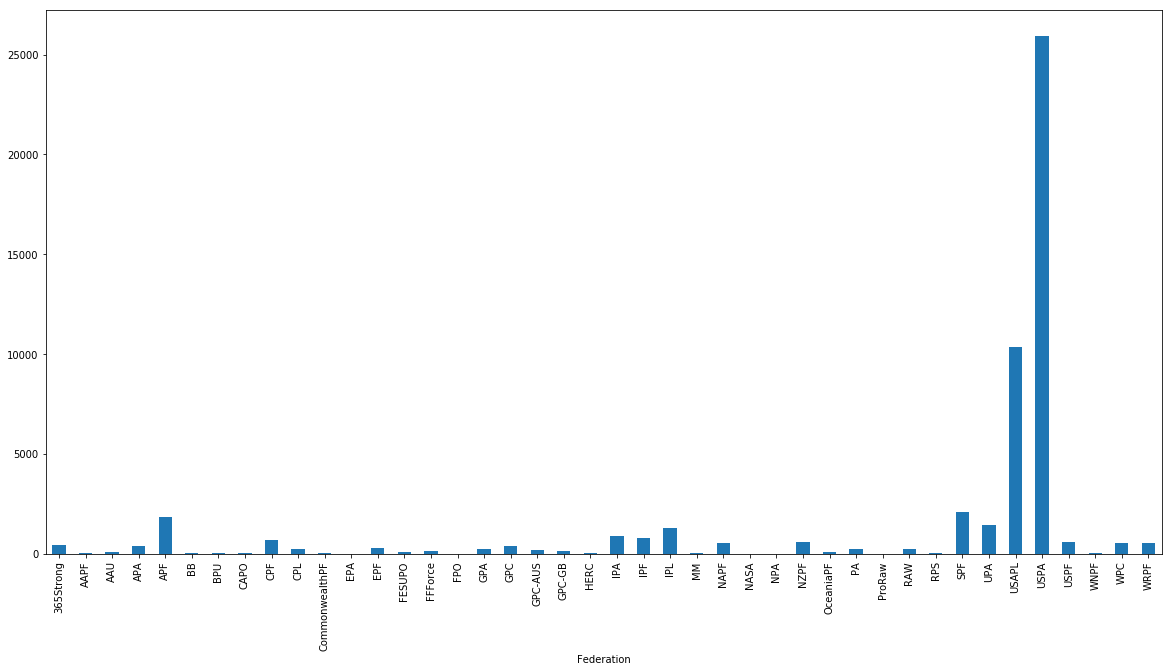

In [14]:
#Choosing strictly United States federation with highest number of participants
merged_df.groupby('Federation').size().plot(kind='bar',figsize = (20,10))

In [15]:
df = merged_df.loc[(merged_df['Federation'] == 'USPA')]

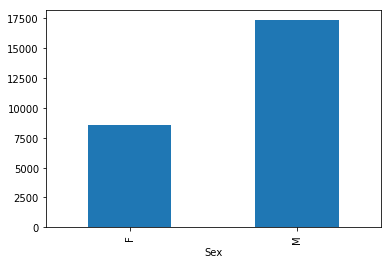

In [16]:
#Checking F/M counts to make sure if we segment the data, there would still be enough to analyze both groups
df.groupby('Sex').size().plot(kind='bar')

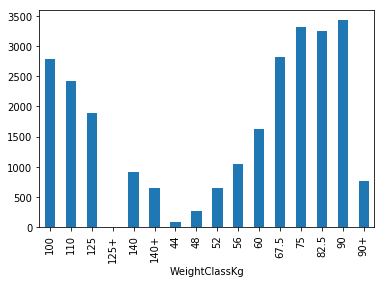

In [17]:
#Will do analysis only on those with a high number of competitors in each weightclass
df.groupby('WeightClassKg').size().plot(kind='bar')

In [18]:
# Getting unique categories to know which categories to drop
df['Equipment'].unique()

array(['Single-ply', 'Raw', 'Multi-ply', 'Wraps'], dtype=object)

In [19]:
#We want to look at RAW strength, Wraps is considered raw in most federations, single/muti-ply lifting 
#means use of specialized equipment to increase weights lifted
df = df.loc[(df['Equipment'] == 'Raw')  | (df['Equipment'] == 'Wraps')]

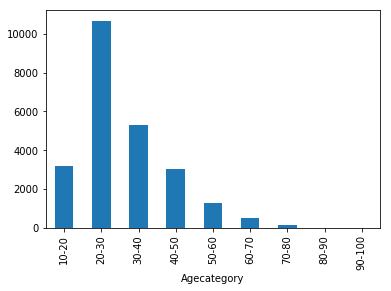

In [20]:
# We will focus on the group that has the most values
df.groupby('Agecategory').size().plot(kind='bar')

In [21]:
df = df.loc[df['Agecategory'] == '20-30']

In [22]:
#Segmenting M/F
m_df = df.loc[df['Sex'] == 'M']
f_df = df.loc[df['Sex'] == 'F']

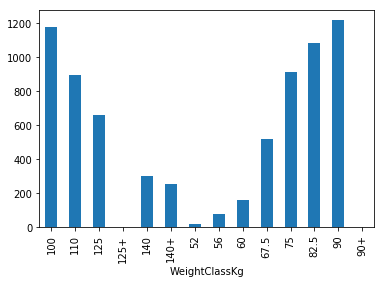

In [23]:
m_df.groupby('WeightClassKg').size().plot(kind='bar')

In [24]:
#Segmenting Data based on weight class, we can't compare the strength of someone of two different weight classes
#Someone who is 110kg's is inherently stronger than someone of a lower weight class
m_70_df = m_df.loc[m_df['WeightClassKg'] == '75']
m_82_df = m_df.loc[m_df['WeightClassKg'] == '82.5']
m_90_df = m_df.loc[m_df['WeightClassKg'] == '90']
m_100_df = m_df.loc[m_df['WeightClassKg'] == '100']
m_110_df = m_df.loc[m_df['WeightClassKg'] == '110']

In [25]:
m_82_df.head()

,MeetID,Federation,Date,Sex,Equipment,Age,Division,BodyweightKg,WeightClassKg,BestSquatKg,BestBenchKg,BestDeadliftKg,TotalKg,Place,Wilks,Agecategory
24436,7553,USPA,2011-05-21,M,Raw,26.0,Open,81.92,82.5,185.0,152.5,200.0,537.5,1,361.610,20-30
24449,7554,USPA,2011-07-01,M,Raw,25.0,Open,78.47,82.5,195.0,130.0,220.0,545.0,1,376.700,20-30
24557,7559,USPA,2011-08-13,M,Raw,23.0,Junior Men 20-23,80.92,82.5,172.5,122.5,192.5,487.5,1,330.443,20-30
24596,7564,USPA,2011-09-10,M,Raw,20.0,Junior Men 20-23,79.61,82.5,207.5,150.0,245.0,602.5,1,412.600,20-30
24642,7567,USPA,2011-10-09,M,Raw,22.0,Jr Men 20-23,80.74,82.5,182.5,125.0,187.5,495.0,1,335.990,20-30


### Indexing Time to Make Time Series Data

In [26]:
# At this point, we only really care about the numbers, so we will drop categories and take the average the meet
# From each month
m_82_ = m_82_df.drop(m_82_df[['MeetID','Federation', 'Sex', 'Equipment', 'Age', 'Division', 'BodyweightKg', 'Place', 'Wilks','Agecategory','WeightClassKg']], axis=1)

#Renaming columns
m_82_ = m_82_.rename(index=str, columns={"BestSquatKg": "SquatKg", "BestBenchKg": "BenchKg", "BestDeadliftKg":"DeadliftKg"})

m_82_['Date'] = pd.to_datetime(m_82_['Date'])
m_82_ = m_82_.set_index('Date')

m_82_.head()

,SquatKg,BenchKg,DeadliftKg,TotalKg
Date,,,,
2011-05-21,185.0,152.5,200.0,537.5
2011-07-01,195.0,130.0,220.0,545.0
2011-08-13,172.5,122.5,192.5,487.5
2011-09-10,207.5,150.0,245.0,602.5
2011-10-09,182.5,125.0,187.5,495.0


In [27]:
m_82 = m_82_[['SquatKg','BenchKg','DeadliftKg', 'TotalKg']].resample('MS').mean()
m_82.index

DatetimeIndex(['2011-05-01', '2011-06-01', '2011-07-01', '2011-08-01',
               '2011-09-01', '2011-10-01', '2011-11-01', '2011-12-01',
               '2012-01-01', '2012-02-01', '2012-03-01', '2012-04-01',
               '2012-05-01', '2012-06-01', '2012-07-01', '2012-08-01',
               '2012-09-01', '2012-10-01', '2012-11-01', '2012-12-01',
               '2013-01-01', '2013-02-01', '2013-03-01', '2013-04-01',
               '2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01',
               '2013-09-01', '2013-10-01', '2013-11-01', '2013-12-01',
               '2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01',
               '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
      

In [28]:
#Forward fill NaN values to impute missing months when competitions did not occur
m_82 = m_82.fillna(method='ffill')
m_82.head()

,SquatKg,BenchKg,DeadliftKg,TotalKg
Date,,,,
2011-05-01,185.0,152.5,200.0,537.5
2011-06-01,185.0,152.5,200.0,537.5
2011-07-01,195.0,130.0,220.0,545.0
2011-08-01,172.5,122.5,192.5,487.5
2011-09-01,207.5,150.0,245.0,602.5


## Exploratory Data Analysis

### Visualizing Trend

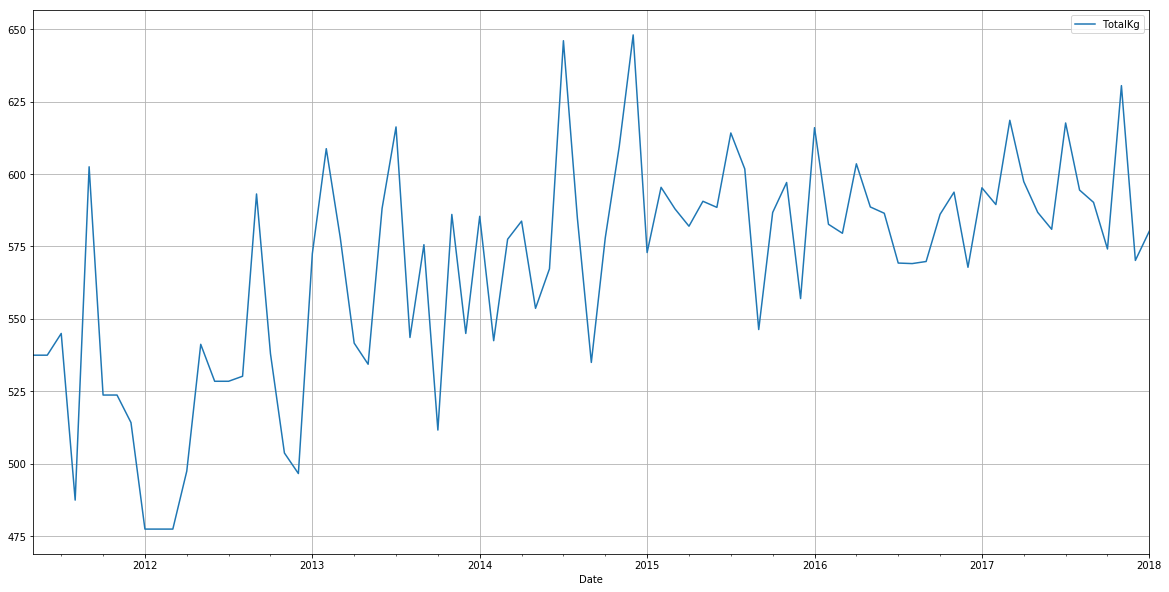

In [29]:
m_82[['TotalKg']].plot(figsize=(20,10), grid = True)

### Identifying Trend with Rolling Average

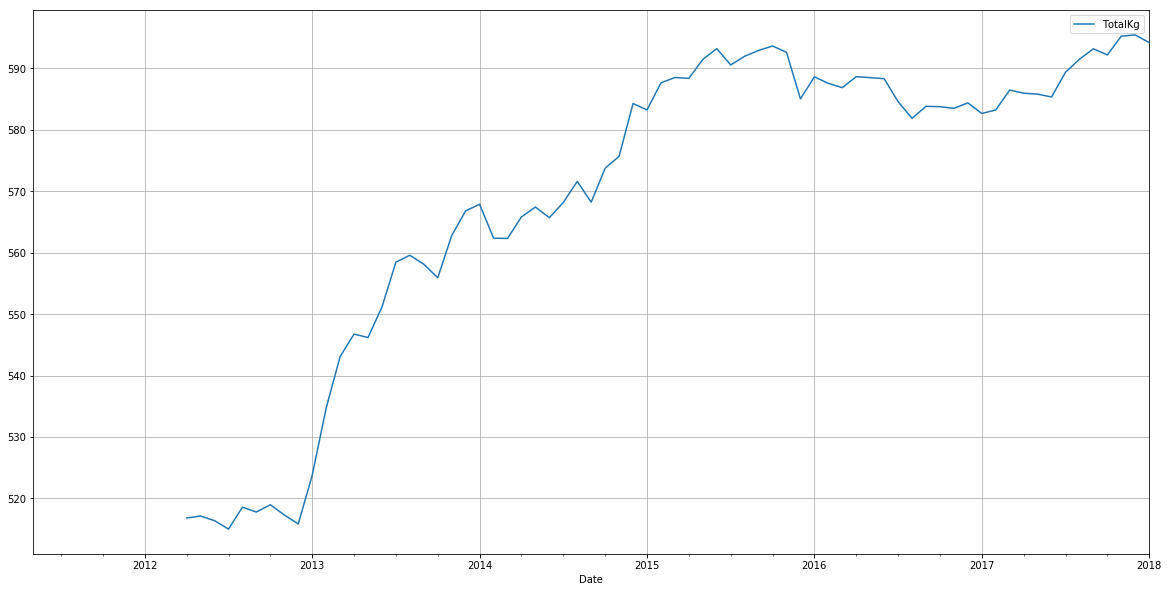

In [30]:
total = m_82[['TotalKg']]
total.rolling(12).mean().plot(figsize=(20,10), grid = True)

### Doing the same for the three seperate lifts

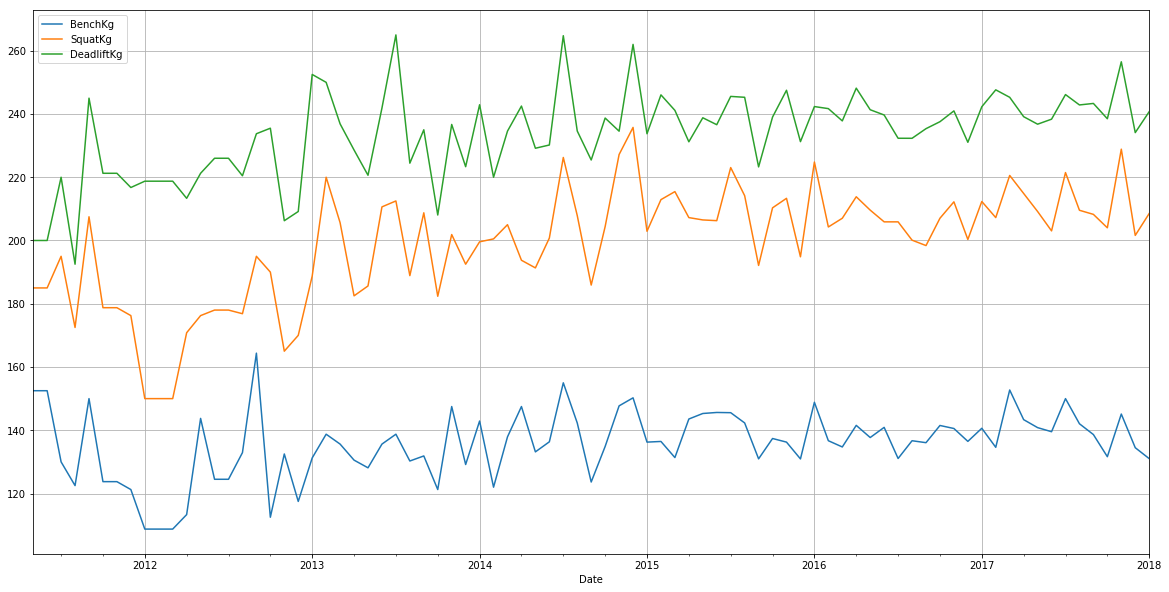

In [31]:
m_82[['BenchKg', 'SquatKg', 'DeadliftKg']].plot(figsize = (20,10), grid = True)

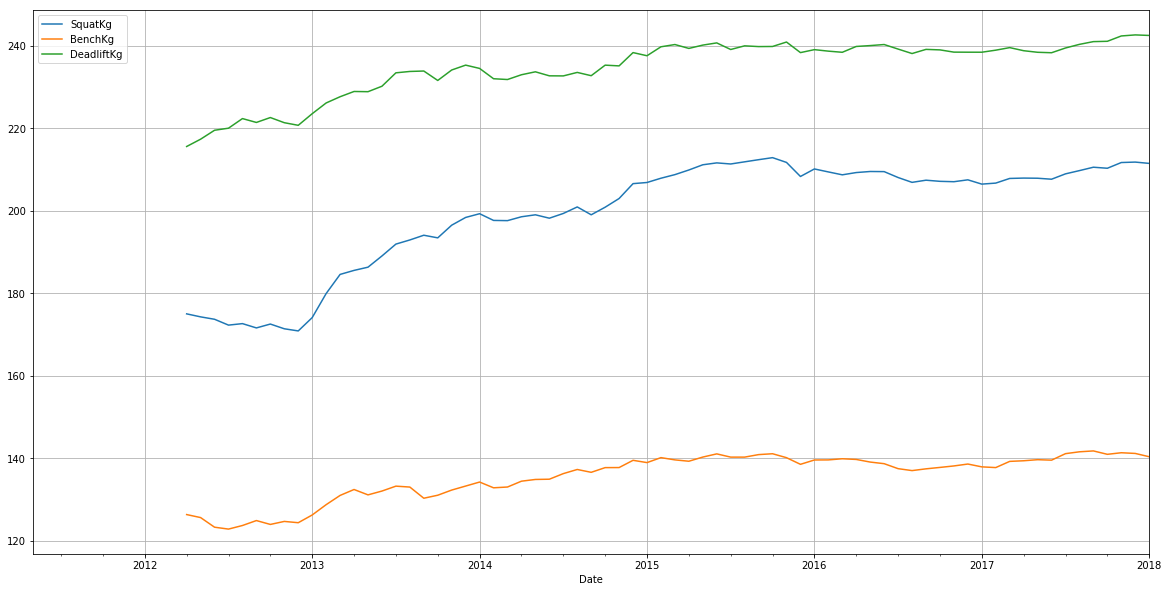

In [32]:
sbd_82 = m_82[['SquatKg', 'BenchKg', 'DeadliftKg']]
sbd_82.rolling(12).mean().plot(figsize=(20,10), grid = True)

### STL Decomposition

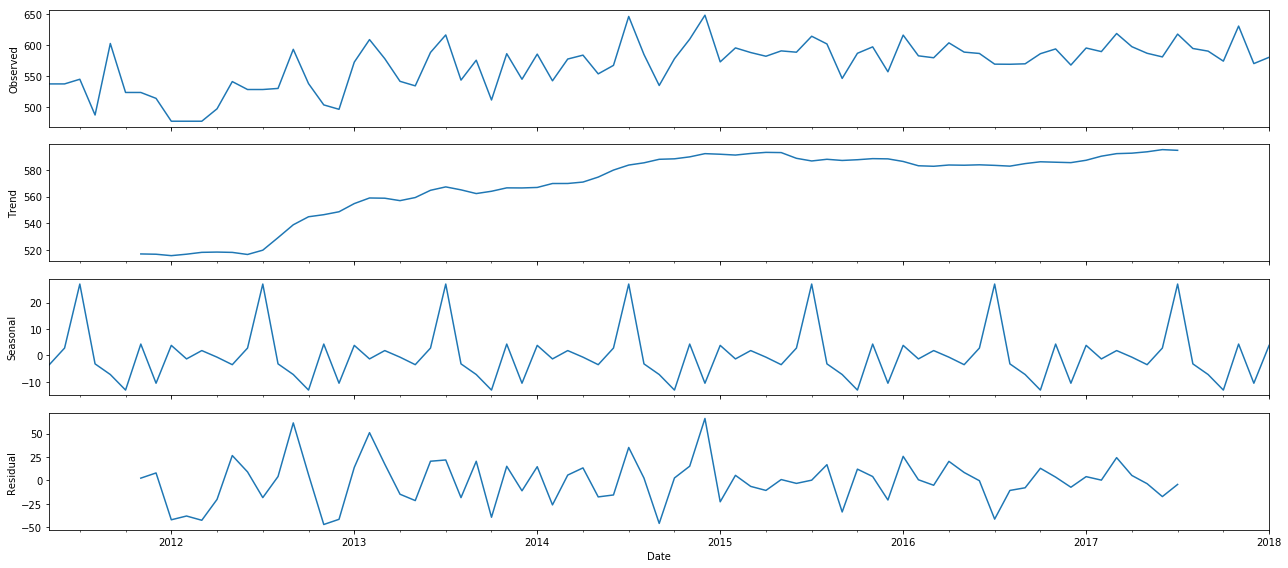

In [33]:
from pylab import rcParams 

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(total, model='additive')
fig = decomposition.plot()
plt.show()

/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


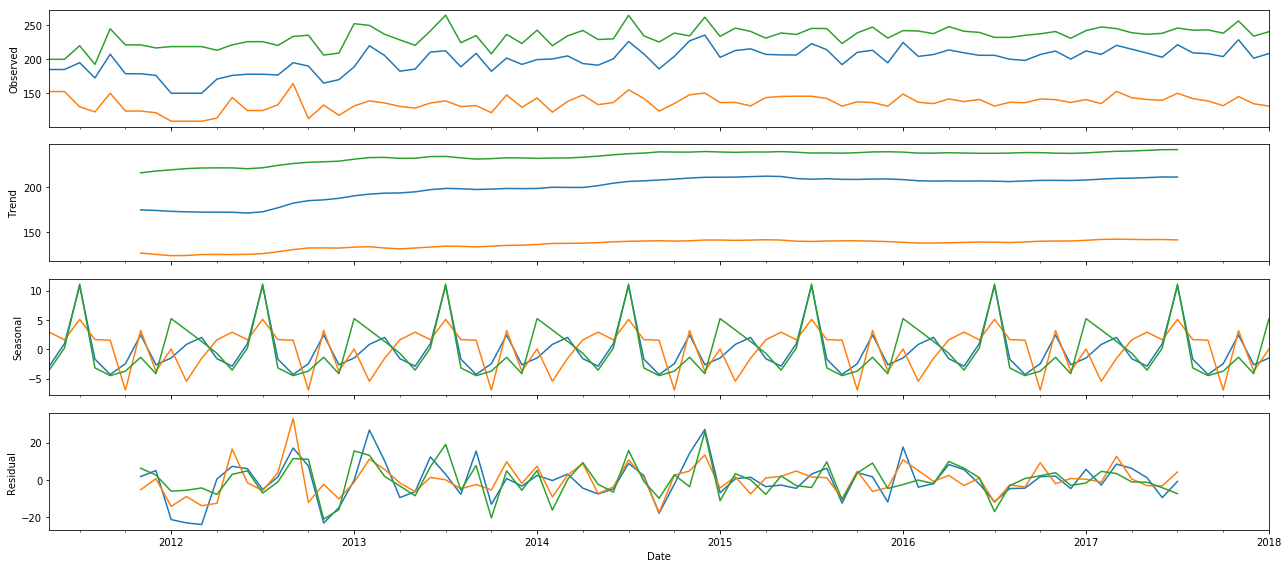

In [34]:
#STL Decomp for three seperate lifts
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(sbd_82, model='additive')
fig = decomposition.plot()
plt.show()

In [35]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)


In [36]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(total, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1244.3249341324304
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:997.9475245135217
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:702.3814851108187
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:564.505147010245
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:708.0739100582987
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:689.9105898058325
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:573.6854009308533
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:563.1418200065149
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1135.067049812475
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:909.1136055436937
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:690.7037674438369
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:553.318952798054


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:710.7810460649334
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:678.1156356999976
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:574.4631227838374
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:555.7099763454465
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:804.7361246149895
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:678.4125087986258
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:718.5587844065902
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:573.4009136644034
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:686.6863832367056
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:678.160676166163
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:591.1491342516231
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:574.4424532392263
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:760.7264995936113
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:635.2480116340049
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:679.7559967237964
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:533.6332526522013
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:653.2104472865057
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:636.7224382565003
ARIMA(0, 1,

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:648.9004701638627
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:554.9536747563528
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:540.2664729720108
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:790.6547511661252
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:668.502934192007
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:709.5770093991682
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:565.3315045842405
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:668.8802858180787
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:669.6715727945971
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:572.2691462759389
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:567.3216198345382
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:762.6459363829352
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:637.2445974692386
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:680.5293081766066
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:535.4948792084513
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:646.0121460075734
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:638.6344583927992
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:550.254308608447
ARIMA(1, 1, 

In [37]:
#Best model from grid search above, least AIC Val

##### ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:533.6332526522013

In [38]:
#Fitting model
mod = sm.tsa.statespace.SARIMAX(total, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8787      0.090     -9.739      0.000      -1.056      -0.702
ma.S.L12      -0.5430      0.107     -5.059      0.000      -0.753      -0.333
sigma2      1000.9844    160.274      6.245      0.000     686.853    1315.115


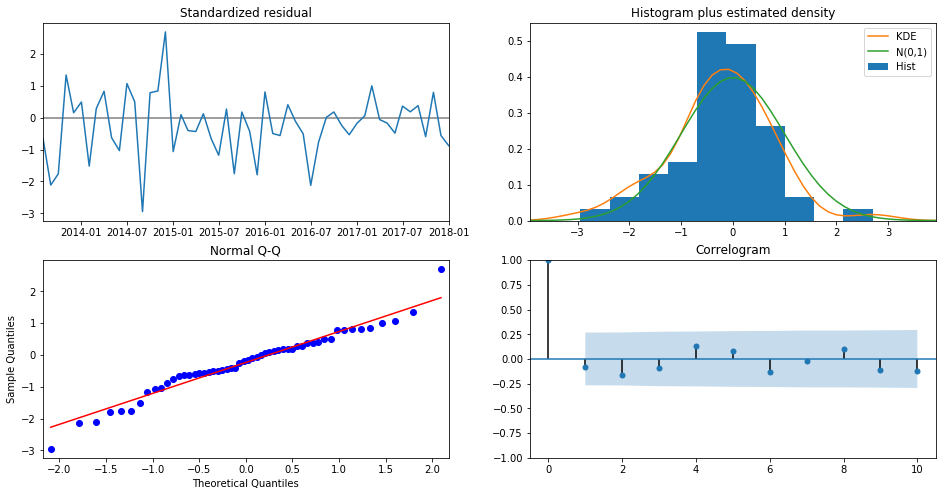

In [39]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

This shows us that our data is normally distributed

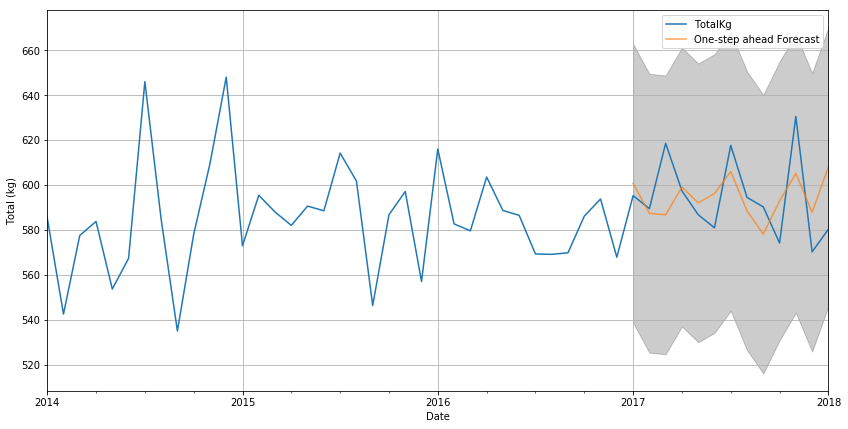

In [40]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = total['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7), grid = True)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Total (kg)')
plt.legend()
plt.show()

In [41]:
total_forecasted = pred.predicted_mean
total_truth = total['2017-01-01':]
mse = ((total_forecasted - total_truth['TotalKg']) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 285.09


In [42]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 16.88


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


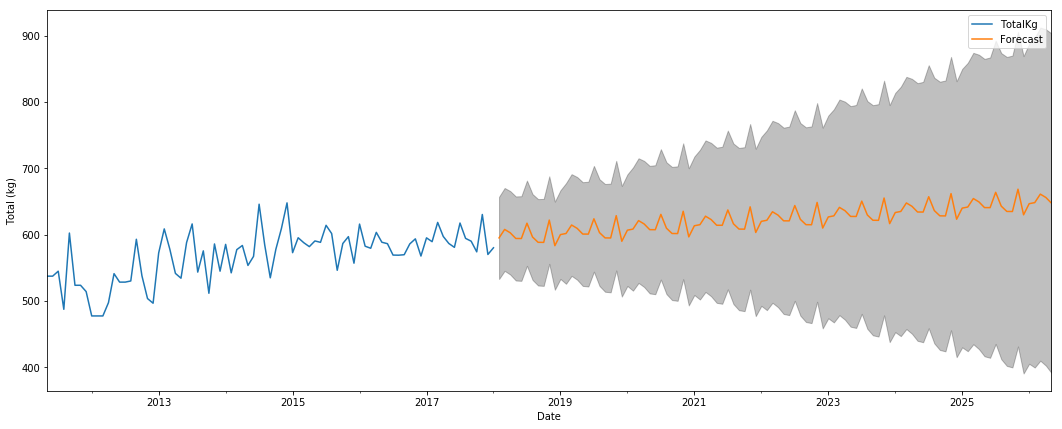

In [43]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = total.plot(label='observed', figsize=(18, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Total (kg)')
plt.legend()
plt.show()